# Assignment 12: RL Prediction with a $\lambda$-twist

### Emile Clastres

## 1) n-Step bootstrapping from scratch.

We are going to draw inspiration from our code for TD. First, we will create a generator to transform the stream of atomic experiences to a stream of n-plet experiences. Then, we will update our approximator for each n-plet.

In [11]:
from typing import Callable, Iterable, Iterator, TypeVar, Tuple

from rl.function_approx import FunctionApprox
import rl.markov_process as mp
import rl.markov_decision_process as mdp
import rl.iterate as iterate

S = TypeVar('S')
from typing import Iterable, Iterator, Tuple, TypeVar, Callable, Mapping
from dataclasses import dataclass
from rl.distribution import Distribution
from rl.function_approx import FunctionApprox
import rl.markov_process as mp
import rl.markov_decision_process as markov_decision_process
from rl.markov_decision_process import (MarkovDecisionProcess)
from rl.returns import returns

S = TypeVar('S')
A = TypeVar('A')

In [83]:
@dataclass(frozen = True)
class n_trans:
    states : Iterable[S]
    rewards : Iterable[float]
    next_states : Iterable[S]

from itertools import islice

def n_transitions(transitions: Iterable[mp.TransitionStep[S]], n:int):
    n_first = list(iter(islice(transitions, n)))
    n_transition = n_trans([s.state for s in n_first],[s.reward for s in n_first],[s.next_state for s in n_first])
    yield n_transition
    for transition in transitions:
        n_transition = n_trans(n_transition.states[1:] + [transition.state],
                              n_transition.rewards[1:] + [transition.reward],
                              n_transition.next_states[1:] + [transition.next_state])
        
        yield n_transition
        

In [106]:
def nstep_tabular_prediction(
        transitions: Iterable[mp.TransitionStep[S]],
        γ: float,
        n : int,
        f : Callable[[int], float] = lambda n : 1/n
        
) -> Mapping[S, float]:

    
    table  :  Mapping[S, float] = dict()
    counts :  Mapping[S, int]   = dict()
    for n_step in n_transitions(transitions,n):
        counts[n_step.states[0]] = counts.get(n_step.states[0], 0) + 1
        Gtn  = sum([r*(γ**i) for i,r in enumerate(n_step.rewards)])
        if counts[n_step.states[0]] == 1:
            table[n_step.states[0]] = n_step.rewards[0]
        else:
            Gtn += (γ**n) * table.get(n_step.next_states[-1], 0.)
            table[n_step.states[0]] = (Gtn - table.get(n_step.states[0], 0.)) * f(counts[n_step.states[0]])+ table.get(n_step.states[0], 0.)
    return table

def nstep_prediction(
        transitions: Iterable[mp.TransitionStep[S]],
        approx_0: FunctionApprox[S],
        γ: float,
    n:int
) -> Iterator[FunctionApprox[S]]:
    '''Evaluate an MRP using TD(0) using the given sequence of
    transitions.

    Each value this function yields represents the approximated value
    function for the MRP after an additional transition.

    Arguments:
      transitions -- a sequence of transitions from an MRP which don't
                     have to be in order or from the same simulation
      approx_0 -- initial approximation of value function
      γ -- discount rate (0 < γ ≤ 1)

    '''
    
    def step(v, n_transition):
        Gtn = sum([r*(γ**i) for i,r in enumerate(n_transition.rewards)]) + (γ**n) * v(n_transition.next_states[-1])
        return v.update([(n_transition.states[0],
                          Gtn )])

    return iterate.accumulate(n_transitions(transitions,n), step, initial=approx_0)

In [107]:
from rl.chapter2.simple_inventory_mrp import SimpleInventoryMRPFinite, InventoryState

user_capacity = 2
user_poisson_lambda = 1.0
user_holding_cost = 1.0
user_stockout_cost = 10.0

user_gamma = 0.9

si_mrp = SimpleInventoryMRPFinite(
    capacity=user_capacity,
    poisson_lambda=user_poisson_lambda,
    holding_cost=user_holding_cost,
    stockout_cost=user_stockout_cost
)

print("Value Function")
print("--------------")
si_mrp.display_value_function(gamma=user_gamma)
print()

Value Function
--------------
{InventoryState(on_hand=1, on_order=0): -28.932,
 InventoryState(on_hand=1, on_order=1): -29.345,
 InventoryState(on_hand=2, on_order=0): -30.345,
 InventoryState(on_hand=0, on_order=2): -28.345,
 InventoryState(on_hand=0, on_order=0): -35.511,
 InventoryState(on_hand=0, on_order=1): -27.932}



In [91]:
def td_tabular_prediction(
        transitions: Iterable[mp.TransitionStep[S]],
        γ: float,
        f : Callable[[int], float] = lambda n : 1/n
) -> Mapping[S, float]:

    
    table  :  Mapping[S, float] = dict()
    counts :  Mapping[S, int]   = dict()

    for step in transitions:
        counts[step.state] = counts.get(step.state, 0) + 1
        if counts[step.state] == 1:
            table[step.state] = step.reward
        else:
            table[step.state] = (step.reward + γ * table.get(step.next_state, 0.) - table.get(step.state, 0.)) * f(counts[step.state])+ table.get(step.state, 0.)
    return table
from rl.chapter2.simple_inventory_mrp import SimpleInventoryMRPFinite, InventoryState
from rl.distribution import Constant
user_capacity = 2
user_poisson_lambda = 1.0
user_holding_cost = 1.0
user_stockout_cost = 10.0

user_gamma = 0.9

si_mrp = SimpleInventoryMRPFinite(
    capacity=user_capacity,
    poisson_lambda=user_poisson_lambda,
    holding_cost=user_holding_cost,
    stockout_cost=user_stockout_cost
)

print("Value Function")
print("--------------")
si_mrp.display_value_function(gamma=user_gamma)
print()


transitions = islice(si_mrp.simulate_reward(Constant(InventoryState(0,0))), 10000)
table_td = td_tabular_prediction(transitions, user_gamma, f = lambda n : 0.05)
table_td

Value Function
--------------
{InventoryState(on_hand=0, on_order=1): -27.932,
 InventoryState(on_hand=0, on_order=0): -35.511,
 InventoryState(on_hand=0, on_order=2): -28.345,
 InventoryState(on_hand=1, on_order=0): -28.932,
 InventoryState(on_hand=2, on_order=0): -30.345,
 InventoryState(on_hand=1, on_order=1): -29.345}



{InventoryState(on_hand=0, on_order=0): -35.16737118821846,
 InventoryState(on_hand=0, on_order=2): -28.30796469046188,
 InventoryState(on_hand=2, on_order=0): -30.735243375855084,
 InventoryState(on_hand=1, on_order=0): -29.701009352762412,
 InventoryState(on_hand=0, on_order=1): -28.585438547972863,
 InventoryState(on_hand=1, on_order=1): -29.668440399584973}

In [108]:
transitions = islice(si_mrp.simulate_reward(Constant(InventoryState(0,0))), 10000)
table_td = nstep_tabular_prediction(transitions, user_gamma, 5, f = lambda n : 0.05)
table_td

{InventoryState(on_hand=0, on_order=0): -35.188993386637286,
 InventoryState(on_hand=0, on_order=2): -28.187642450600755,
 InventoryState(on_hand=2, on_order=0): -31.614480412821827,
 InventoryState(on_hand=1, on_order=0): -29.821772593105305,
 InventoryState(on_hand=1, on_order=1): -29.410699826970784,
 InventoryState(on_hand=0, on_order=1): -28.349067843496847}

## 2) TD($\lambda$)

In [109]:
def tdlambda_tabular_prediction(
        transitions: Iterable[mp.TransitionStep[S]],
        γ: float,
        λ : float,
        α : float,
        S : Iterable[S],
        
) -> Mapping[S, float]:

    
    table  :  Mapping[S, float] = dict()
    E      :  Mapping[S, float] = dict()
        
    for tr in transitions:
        Gt = tr.reward + γ*table.get(tr.next_state, 0.)
        for s in S:
            E[s] = E.get(s, 0.) * λ *γ + float(s==tr.state)
            table[s] = table.get(s, 0.) + α*(Gt - table.get(tr.state, 0.))*E[s]
    return table


In [117]:
user_lambda = 0.5
transitions = islice(si_mrp.simulate_reward(Constant(InventoryState(0,0))), 10000)
table_td = tdlambda_tabular_prediction(transitions, user_gamma,user_lambda,0.1, si_mrp.states())
table_td

{InventoryState(on_hand=0, on_order=0): -35.568423360076636,
 InventoryState(on_hand=0, on_order=1): -26.793888211241494,
 InventoryState(on_hand=0, on_order=2): -28.10065649172422,
 InventoryState(on_hand=1, on_order=0): -28.447513972367545,
 InventoryState(on_hand=1, on_order=1): -28.314318822329533,
 InventoryState(on_hand=2, on_order=0): -29.050811106856344}

### Success !

## 3) MC Error as a sum of discounted TD errors

Let $MC_t$ be the Monte-Carlo error and $\delta_t$ the TD-error at timestep t.

MC error is defined as $$MC_t = G_t - V(S_t) =  R_t + \gamma G_{t+1} - V(S_t) = (R_t + \gamma V(S_{t+1}) - V(S_t)) + \gamma (G_{t+1} - V(S_{t+1}) = \delta_t + \gamma MC_{t+1}$$

Therefore, using $MC_T = 0$ we can rewrite the sequence $MC_t$ as $$MC_t = \sum_{u=t}^{T-1} \gamma^{u-t}\delta_u$$ 
Which is the desired identity.

## 4) About the  $\lambda$ in TD($\lambda$)

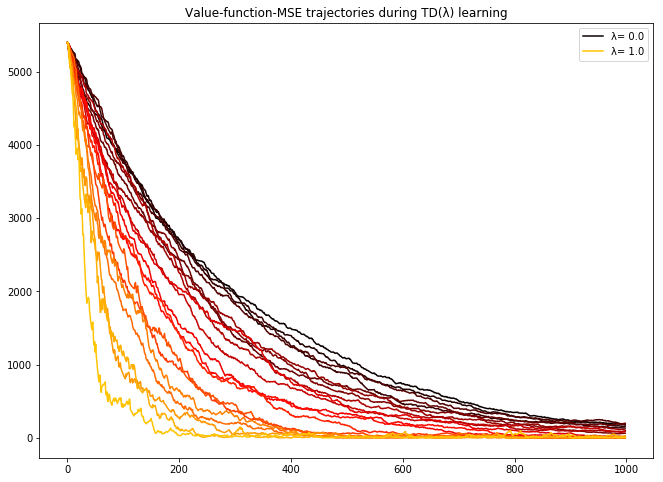

In [154]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm


def tdlambda_tabular_prediction_incremental(
        transitions: Iterable[mp.TransitionStep[S]],
        γ: float,
        λ : float,
        α : float,
        S : Iterable[S],
        
) -> Iterable[Mapping[S, float]]:

    
    table  :  Mapping[S, float] = dict()
    E      :  Mapping[S, float] = dict()
        
    for tr in transitions:
        Gt = tr.reward + γ*table.get(tr.next_state, 0.)
        for s in S:
            E[s] = E.get(s, 0.) * λ *γ + float(s==tr.state)
            table[s] = table.get(s, 0.) + α*(Gt - table.get(tr.state, 0.))*E[s]
        yield table

    
TRUE_TABLE  = {
            si_mrp.non_terminal_states[i]: r
            for i, r in enumerate(si_mrp.get_value_function_vec(user_gamma))
        }

def table_rmse(table, true_table = TRUE_TABLE):
    return sum([(table[i] - true_table[i])**2 for i in true_table])

lambdas = np.linspace(0,1,20)
trajectories = {}
STEPS = 1000
for lam in lambdas:
    transitions = islice(si_mrp.simulate_reward(Constant(InventoryState(0,0))), STEPS)
    tables = islice(tdlambda_tabular_prediction_incremental(transitions, user_gamma,lam,0.1, si_mrp.states()), STEPS-1)
    trajectories[lam] = [table_rmse(table) for table in tables]

plt.figure(figsize = (11,8))
for lam, traj in trajectories.items():
    if lam in [0., 1.]:
        plt.plot(traj, c = cm.hot(0.66*lam), label = f'λ= {lam}')
    else:
        plt.plot(traj, c = cm.hot(0.66*lam))
plt.legend()
plt.title('Value-function-MSE trajectories during TD(λ) learning')
plt.show()